<a href="https://colab.research.google.com/github/tirth-jarsania/Deep-Learning/blob/main/gdalgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation , rc
from IPython.display import HTML

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["green","yellow","red"])

In [ ]:
class SN:

  def __init__(self , w_init , b_init , algo ):
    self.w = w_init
    self.b = b_init
    self.algo = algo
    self.w_h = []
    self.b_h = []
    self.e_h = []

  def sigmoid(self , x , w = None , b = None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1. / (1. + np.exp(-(w*x + b)))

  def error(self , X , Y , w = None , b = None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    for x,y in zip(X,Y):
      err += 0.5 * ( self.sigmoid(x,w,b) - y) ** 2
    return err

  def grad_w(self , x, y, w=None , b=None ):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred-y)*y_pred*(1-y_pred)*x

  def grad_b(self , x, y, w=None , b=None ):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred-y)*y_pred*(1-y_pred)

  def fit(self, X, Y, epochs = 100 , eta = 0.01 , gamma = 0.9  , mini_batch_size = 100 , eps = 1e-8 , beta = 0.9 , beta1 = 0.9 , beta2 = 0.9 ):
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.X = X
    self.Y = Y

    if self.algo == 'GD':
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        self.w -= ( eta * dw ) / X.shape[0]
        self.b -= ( eta * db ) / X.shape[0]
        self.append_log()

    elif self.algo == 'Momentum':
      v_w_prev , v_b_prev = 0 , 0
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        v_w = gamma * v_w_prev + ( eta * dw ) / X.shape[0]
        v_b = gamma * v_b_prev + ( eta * db ) / X.shape[0]
        self.w = self.w - v_w
        self.b = self.b - v_b
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == 'NAG':
      v_w_prev , v_b_prev = 0 , 0
      for i in range( epochs ):
        dw , db = 0 , 0 
        w_temp = self.w - gamma * v_w_prev
        b_temp = self.b - gamma * v_b_prev
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y,w_temp,b_temp)
          db += self.grad_b(x,y,w_temp,b_temp)
        v_w = gamma * v_w_prev + ( eta * dw ) / X.shape[0]
        v_b = gamma * v_b_prev + ( eta * db ) / X.shape[0]
        self.w = w_temp - ( eta * dw ) / X.shape[0]
        self.b = b_temp - ( eta * db ) / X.shape[0]
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == "MiniBatch":
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        if (i+1) % mini_batch_size == 0 :
          self.w -= ( eta * dw ) / mini_batch_size
          self.b -= ( eta * db ) / mini_batch_size
          dw = 0
          db = 0
          self.append_log()

    elif self.algo == 'AdaGrad':
      v_w , v_b = 0
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)

        v_w += dw**2
        v_b += db**2

        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()

    elif self.algo == 'RMSProp':
      v_w , v_b = 0
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)

      v_w = beta * v_w + (1-beta) * (dw**2)
      v_b = beta * v_b + (1-beta) * (db**2)
      self.w -= (eta / np.sqrt(v_w) + eps) * dw
      self.b -= (eta / np.sqrt(v_b) + eps) * db
      self.append_log()

    elif self.algo == 'Adam':
      v_w , v_b = 0, 0
      m_w , m_b = 0, 0
      num_updates = 0
      for i in range( epochs ):
        dw , db = 0 , 0 
        for x,y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        num_updates += 1
        m_w = beta1 * m_w + (1-beta1) * dw
        m_b = beta1 * m_b + (1-beta1) * db
        v_w = beta2 * v_w + (1-beta2) * (dw**2)
        v_b = beta2 * v_b + (1-beta2) * (db**2)
        m_w_c = m_w / (1 - np.power(beta1 , num_updates))
        m_b_c = m_b / (1 - np.power(beta1 , num_updates))
        v_w_c = v_w / (1 - np.power(beta2 , num_updates))
        v_b_c = v_b / (1 - np.power(beta2 , num_updates))
        self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_c
        self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
        self.append_log()

  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X , self.Y))



In [ ]:
x = np.asarray([0.5, 2.5])
y = np.asarray([0.2, 0.9])

algo = 'GD'

w_init = -2
b_init = -2

epochs = 1000
eta = 1

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frams = 20
plot_3d = True
plot_2d = False

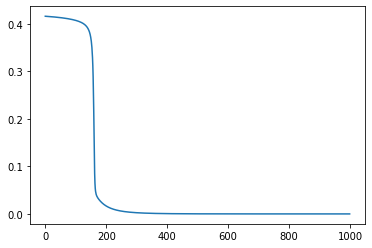

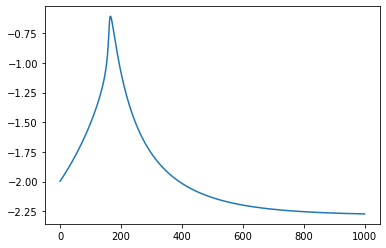

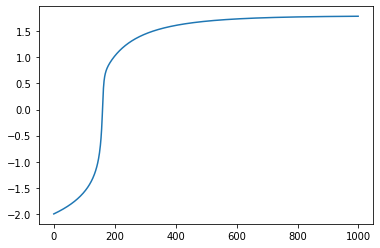

In [ ]:
sn = SN(w_init , b_init , algo)
sn.fit(x, y, epochs , eta)
plt.plot(sn.e_h)
plt.show()
plt.plot(sn.b_h)
plt.show()
plt.plot(sn.w_h)
plt.show()